# Data Ingestion

In [ ]:
import scipy.io as sio

kuka_data = sio.loadmat('../data/KukaDirectDynamics.mat')

In [2]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [3]:
import numpy as np

trajectories = {}
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
        trajectories[key] = value

In [4]:
train_traj_key = 'kukatraj1'
test_traj_key = 'kukatraj2'

train_data = trajectories[train_traj_key]
test_data = trajectories[test_traj_key]

# Inputs: joint positions (7), velocities (7), torques (7)
X_train = train_data[:, :21]
# Targets: next joint positions (7), next joint velocities (7)
y_train = train_data[:, 21:]

X_test = test_data[:, :21]
y_test = test_data[:, 21:]

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")
print(f"Number of input features: {X_train.shape[1]}")
print(f"Number of output targets: {y_train.shape[1]}")

Number of training samples: 1814
Number of testing samples: 1857
Number of input features: 21
Number of output targets: 14


In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on device: {device}")

# 1. Define your data splits
# Pool most trajectories for training/validation during optimization.
# Hold out 1-2 trajectories that the model will NEVER see during optimization.
train_val_keys = [f'kukatraj{i}' for i in range(1, 9)]  # e.g., Trajectories 1-8
final_test_keys = ['kukatraj9', 'kukatraj10']         # e.g., Trajectories 9-10

# 2. Create the combined training/validation data pool
train_val_list = [trajectories[key] for key in train_val_keys if key in trajectories]
full_train_data = np.concatenate(train_val_list, axis=0)

# 3. Create the final, held-out test set
test_list = [trajectories[key] for key in final_test_keys if key in trajectories]
full_test_data = np.concatenate(test_list, axis=0)

# 4. Create full X and y tensors and move them to the GPU
# This is the data pool Optuna's K-Fold will use.
X_train_full = torch.from_numpy(full_train_data[:, :21]).float().to(device)
y_train_full = torch.from_numpy(full_train_data[:, 21:]).float().to(device)

# This is the data for the final performance report AFTER optimization.
X_test_final = torch.from_numpy(full_test_data[:, :21]).float().to(device)
y_test_final = torch.from_numpy(full_test_data[:, 21:]).float().to(device)

print(f"Training/Validation pool shape: {X_train_full.shape}")
print(f"Final held-out test set shape: {X_test_final.shape}")

Running on device: cuda
Training/Validation pool shape: torch.Size([16052, 21])
Final held-out test set shape: torch.Size([4016, 21])


# Optimisation
---

In [ ]:
import optuna
from sklearn.model_selection import KFold
import sys
sys.path.append('../pc_esn')

import model
import utils

def objective(trial):
    """
    The objective function for Optuna to optimize.
    It uses the pre-loaded GPU tensors for K-Fold Cross-Validation.
    """
    # 1. Hyperparameters
    params = {
        'n_reservoir': trial.suggest_int('n_reservoir', 50, 1000),
        'spectral_radius': trial.suggest_float('spectral_radius', 0.5, 1),
        'sparsity': trial.suggest_float('sparsity', 0.6, 0.95),
        'leak_rate': trial.suggest_float('leak_rate', 0.1, 0.5),
        'ghl_eta': trial.suggest_float('ghl_eta', 1e-6, 1e-3, log=True),
        'ghl_decay_steps': trial.suggest_int('ghl_decay_steps', 1000, 10000)
    }

    # 2. Perform K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_errors = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        print(f"--- Trial {trial.number}, Fold {fold+1} ---")
        
        # Slicing creates views of the GPU tensors, no data is moved
        X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
        y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

        # Instantiate the model with trial params
        model = model.PC_ESN(
            n_inputs=X_train.shape[1],
            n_outputs=y_train.shape[1],
            n_reservoir=params['n_reservoir'],
            spectral_radius=params['spectral_radius'],
            sparsity=params['sparsity'],
            leak_rate=params['leak_rate'],
            ghl_eta=params['ghl_eta'],
            ghl_decay_steps=params['ghl_decay_steps'],
            device=device  # Pass the device to the model
        )

        model.train(X_train, y_train)
        predictions = model.predict_full_trajectory(X_val)
        
        # Calculate nMSE
        true_values = y_val.cpu().numpy() # Move to CPU only for numpy calculation
        error = np.mean((predictions - true_values)**2)
        variance = np.var(true_values)
        
        # Avoid division by zero if variance is tiny
        nMSE = error / (variance + 1e-9)
        fold_errors.append(nMSE)

    # 3. Return the average error across all folds
    average_nMSE = np.mean(fold_errors)
    print(f"--- Trial {trial.number} complete. Average nMSE: {average_nMSE:.6f} ---")
    
    return average_nMSE

In [ ]:
# Create a study object. "minimize" is the goal for our error metric.
study = optuna.create_study(direction='minimize')

# Start the optimization
study.optimize(objective, n_trials=20)

# After the study is complete, you can get the best results.
print("Optimization finished!")
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (nMSE): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-07 09:02:58,417] A new study created in memory with name: no-name-9e5b2166-4f3c-4eef-8154-6c1df3e032d4


--- Trial 0, Fold 1 ---
--- Trial 0, Fold 2 ---
--- Trial 0, Fold 3 ---
--- Trial 0, Fold 4 ---
--- Trial 0, Fold 5 ---


[I 2025-07-07 09:08:37,596] Trial 0 finished with value: 1.9049762658622087 and parameters: {'n_reservoir': 452, 'spectral_radius': 0.9476727091648204, 'sparsity': 0.9070650410035443, 'leak_rate': 0.4238464633239838, 'ghl_eta': 4.224313596190441e-06, 'ghl_decay_steps': 1399}. Best is trial 0 with value: 1.9049762658622087.


--- Trial 0 complete. Average nMSE: 1.904976 ---
--- Trial 1, Fold 1 ---
--- Trial 1, Fold 2 ---
--- Trial 1, Fold 3 ---
--- Trial 1, Fold 4 ---
--- Trial 1, Fold 5 ---


[I 2025-07-07 09:14:19,751] Trial 1 finished with value: 0.833516684791236 and parameters: {'n_reservoir': 512, 'spectral_radius': 0.7608890639170074, 'sparsity': 0.7639998007585289, 'leak_rate': 0.3613075000895152, 'ghl_eta': 7.782634864444159e-05, 'ghl_decay_steps': 2658}. Best is trial 1 with value: 0.833516684791236.


--- Trial 1 complete. Average nMSE: 0.833517 ---
--- Trial 2, Fold 1 ---
--- Trial 2, Fold 2 ---
--- Trial 2, Fold 3 ---
--- Trial 2, Fold 4 ---
--- Trial 2, Fold 5 ---


[I 2025-07-07 09:19:57,861] Trial 2 finished with value: 2.001549064534107 and parameters: {'n_reservoir': 264, 'spectral_radius': 0.7530488717477342, 'sparsity': 0.6466887580923932, 'leak_rate': 0.4144258515432585, 'ghl_eta': 1.64510125230859e-05, 'ghl_decay_steps': 9083}. Best is trial 1 with value: 0.833516684791236.


--- Trial 2 complete. Average nMSE: 2.001549 ---
--- Trial 3, Fold 1 ---
--- Trial 3, Fold 2 ---
--- Trial 3, Fold 3 ---
--- Trial 3, Fold 4 ---
--- Trial 3, Fold 5 ---


[I 2025-07-07 09:25:22,508] Trial 3 finished with value: 2.453396610301987 and parameters: {'n_reservoir': 71, 'spectral_radius': 0.9606729854859053, 'sparsity': 0.7847585322201068, 'leak_rate': 0.14585665627801916, 'ghl_eta': 1.7142006857467203e-05, 'ghl_decay_steps': 9835}. Best is trial 1 with value: 0.833516684791236.


--- Trial 3 complete. Average nMSE: 2.453397 ---
--- Trial 4, Fold 1 ---
--- Trial 4, Fold 2 ---
--- Trial 4, Fold 3 ---
--- Trial 4, Fold 4 ---
--- Trial 4, Fold 5 ---


[I 2025-07-07 09:31:00,568] Trial 4 finished with value: 3.626236638475593 and parameters: {'n_reservoir': 192, 'spectral_radius': 0.5099444360173366, 'sparsity': 0.903099294505315, 'leak_rate': 0.20832158269213472, 'ghl_eta': 2.9380206980613616e-06, 'ghl_decay_steps': 2005}. Best is trial 1 with value: 0.833516684791236.


--- Trial 4 complete. Average nMSE: 3.626237 ---
--- Trial 5, Fold 1 ---
--- Trial 5, Fold 2 ---
--- Trial 5, Fold 3 ---
--- Trial 5, Fold 4 ---
--- Trial 5, Fold 5 ---


[I 2025-07-07 09:36:38,921] Trial 5 finished with value: 0.9460752428580506 and parameters: {'n_reservoir': 248, 'spectral_radius': 0.8543461910079797, 'sparsity': 0.9372362920130914, 'leak_rate': 0.4661302304385232, 'ghl_eta': 0.0005046357451059754, 'ghl_decay_steps': 5133}. Best is trial 1 with value: 0.833516684791236.


--- Trial 5 complete. Average nMSE: 0.946075 ---
--- Trial 6, Fold 1 ---
--- Trial 6, Fold 2 ---
--- Trial 6, Fold 3 ---
--- Trial 6, Fold 4 ---
--- Trial 6, Fold 5 ---


[I 2025-07-07 09:44:13,908] Trial 6 finished with value: 0.5833686796052064 and parameters: {'n_reservoir': 962, 'spectral_radius': 0.9621413228330296, 'sparsity': 0.6379168629389625, 'leak_rate': 0.35642867102776843, 'ghl_eta': 4.398649467059913e-06, 'ghl_decay_steps': 6515}. Best is trial 6 with value: 0.5833686796052064.


--- Trial 6 complete. Average nMSE: 0.583369 ---
--- Trial 7, Fold 1 ---
--- Trial 7, Fold 2 ---
--- Trial 7, Fold 3 ---
--- Trial 7, Fold 4 ---
--- Trial 7, Fold 5 ---


[W 2025-07-07 09:50:01,499] Trial 7 failed with parameters: {'n_reservoir': 647, 'spectral_radius': 0.7569935249590274, 'sparsity': 0.627253093892078, 'leak_rate': 0.21947093876320667, 'ghl_eta': 0.000831753781365127, 'ghl_decay_steps': 7414} because of the following error: The value nan is not acceptable.
[W 2025-07-07 09:50:01,500] Trial 7 failed with value nan.


--- Trial 7 complete. Average nMSE: nan ---
--- Trial 8, Fold 1 ---
--- Trial 8, Fold 2 ---
--- Trial 8, Fold 3 ---
--- Trial 8, Fold 4 ---
--- Trial 8, Fold 5 ---


[I 2025-07-07 09:55:43,593] Trial 8 finished with value: 1.73109798549863 and parameters: {'n_reservoir': 562, 'spectral_radius': 0.5329612418051183, 'sparsity': 0.9038497679735976, 'leak_rate': 0.24190957625384849, 'ghl_eta': 0.00011405513877376539, 'ghl_decay_steps': 3075}. Best is trial 6 with value: 0.5833686796052064.


--- Trial 8 complete. Average nMSE: 1.731098 ---
--- Trial 9, Fold 1 ---
--- Trial 9, Fold 2 ---
--- Trial 9, Fold 3 ---
--- Trial 9, Fold 4 ---
--- Trial 9, Fold 5 ---


[I 2025-07-07 10:01:27,606] Trial 9 finished with value: 0.7639142259001376 and parameters: {'n_reservoir': 617, 'spectral_radius': 0.5033149990651029, 'sparsity': 0.7042741247506431, 'leak_rate': 0.34691046413461346, 'ghl_eta': 0.0001796640962867693, 'ghl_decay_steps': 1346}. Best is trial 6 with value: 0.5833686796052064.


--- Trial 9 complete. Average nMSE: 0.763914 ---
--- Trial 10, Fold 1 ---
--- Trial 10, Fold 2 ---
--- Trial 10, Fold 3 ---
--- Trial 10, Fold 4 ---
--- Trial 10, Fold 5 ---


[I 2025-07-07 10:07:18,258] Trial 10 finished with value: 0.6518642728083524 and parameters: {'n_reservoir': 646, 'spectral_radius': 0.6754917947984009, 'sparsity': 0.8758263717361227, 'leak_rate': 0.3739366856759767, 'ghl_eta': 0.00040885901069712724, 'ghl_decay_steps': 8114}. Best is trial 6 with value: 0.5833686796052064.


--- Trial 10 complete. Average nMSE: 0.651864 ---
--- Trial 11, Fold 1 ---
--- Trial 11, Fold 2 ---
--- Trial 11, Fold 3 ---
--- Trial 11, Fold 4 ---
--- Trial 11, Fold 5 ---


[I 2025-07-07 10:14:09,759] Trial 11 finished with value: 0.7106196721044166 and parameters: {'n_reservoir': 939, 'spectral_radius': 0.8561140475611966, 'sparsity': 0.6336211069241066, 'leak_rate': 0.2757841025802454, 'ghl_eta': 1.387719294722538e-06, 'ghl_decay_steps': 6627}. Best is trial 6 with value: 0.5833686796052064.


--- Trial 11 complete. Average nMSE: 0.710620 ---
--- Trial 12, Fold 1 ---
--- Trial 12, Fold 2 ---
--- Trial 12, Fold 3 ---
--- Trial 12, Fold 4 ---
--- Trial 12, Fold 5 ---


[I 2025-07-07 10:20:56,993] Trial 12 finished with value: 0.7779642376731579 and parameters: {'n_reservoir': 928, 'spectral_radius': 0.6373429312112864, 'sparsity': 0.8292349081797049, 'leak_rate': 0.3330632377560459, 'ghl_eta': 0.0005182355441177991, 'ghl_decay_steps': 7384}. Best is trial 6 with value: 0.5833686796052064.


--- Trial 12 complete. Average nMSE: 0.777964 ---
--- Trial 13, Fold 1 ---
--- Trial 13, Fold 2 ---
--- Trial 13, Fold 3 ---
--- Trial 13, Fold 4 ---
--- Trial 13, Fold 5 ---


[I 2025-07-07 10:26:45,266] Trial 13 finished with value: 0.5075042656872436 and parameters: {'n_reservoir': 775, 'spectral_radius': 0.6653020696391257, 'sparsity': 0.8482914935219255, 'leak_rate': 0.3982377895018535, 'ghl_eta': 8.496352545341698e-06, 'ghl_decay_steps': 8110}. Best is trial 13 with value: 0.5075042656872436.


--- Trial 13 complete. Average nMSE: 0.507504 ---
--- Trial 14, Fold 1 ---
--- Trial 14, Fold 2 ---
--- Trial 14, Fold 3 ---
--- Trial 14, Fold 4 ---
--- Trial 14, Fold 5 ---


[I 2025-07-07 10:32:33,380] Trial 14 finished with value: 0.5037056277286454 and parameters: {'n_reservoir': 796, 'spectral_radius': 0.6152081394698712, 'sparsity': 0.7241722484266282, 'leak_rate': 0.4945360708649757, 'ghl_eta': 8.496869161980125e-06, 'ghl_decay_steps': 5372}. Best is trial 14 with value: 0.5037056277286454.


--- Trial 14 complete. Average nMSE: 0.503706 ---
--- Trial 15, Fold 1 ---
--- Trial 15, Fold 2 ---
--- Trial 15, Fold 3 ---
--- Trial 15, Fold 4 ---
--- Trial 15, Fold 5 ---


[I 2025-07-07 10:38:21,250] Trial 15 finished with value: 0.5068207066118358 and parameters: {'n_reservoir': 784, 'spectral_radius': 0.6176299177651832, 'sparsity': 0.7267128790220115, 'leak_rate': 0.4887372025235418, 'ghl_eta': 1.052769255771376e-05, 'ghl_decay_steps': 4789}. Best is trial 14 with value: 0.5037056277286454.


--- Trial 15 complete. Average nMSE: 0.506821 ---
--- Trial 16, Fold 1 ---
--- Trial 16, Fold 2 ---
--- Trial 16, Fold 3 ---
--- Trial 16, Fold 4 ---
--- Trial 16, Fold 5 ---


[I 2025-07-07 10:44:08,752] Trial 16 finished with value: 0.6594710158677495 and parameters: {'n_reservoir': 775, 'spectral_radius': 0.5913826213709716, 'sparsity': 0.7094030882275394, 'leak_rate': 0.47547188654891237, 'ghl_eta': 4.215160904036021e-05, 'ghl_decay_steps': 4564}. Best is trial 14 with value: 0.5037056277286454.


--- Trial 16 complete. Average nMSE: 0.659471 ---
--- Trial 17, Fold 1 ---
--- Trial 17, Fold 2 ---
--- Trial 17, Fold 3 ---
--- Trial 17, Fold 4 ---
--- Trial 17, Fold 5 ---


[I 2025-07-07 10:50:00,534] Trial 17 finished with value: 0.5718262029933794 and parameters: {'n_reservoir': 741, 'spectral_radius': 0.5891338776143665, 'sparsity': 0.7238338284461092, 'leak_rate': 0.49677811779959513, 'ghl_eta': 2.1956645884231506e-05, 'ghl_decay_steps': 4161}. Best is trial 14 with value: 0.5037056277286454.


--- Trial 17 complete. Average nMSE: 0.571826 ---
--- Trial 18, Fold 1 ---
--- Trial 18, Fold 2 ---
--- Trial 18, Fold 3 ---
--- Trial 18, Fold 4 ---
--- Trial 18, Fold 5 ---


[I 2025-07-07 10:55:47,774] Trial 18 finished with value: 0.48609351749696605 and parameters: {'n_reservoir': 843, 'spectral_radius': 0.7114627062744192, 'sparsity': 0.7582176802614979, 'leak_rate': 0.4370435203250815, 'ghl_eta': 1.265504357019225e-06, 'ghl_decay_steps': 5926}. Best is trial 18 with value: 0.48609351749696605.


--- Trial 18 complete. Average nMSE: 0.486094 ---
--- Trial 19, Fold 1 ---
--- Trial 19, Fold 2 ---
--- Trial 19, Fold 3 ---
--- Trial 19, Fold 4 ---
--- Trial 19, Fold 5 ---


[I 2025-07-07 11:01:27,410] Trial 19 finished with value: 1.4284828583004907 and parameters: {'n_reservoir': 424, 'spectral_radius': 0.6893748038778699, 'sparsity': 0.7904681453750124, 'leak_rate': 0.43270783730588697, 'ghl_eta': 1.1005023802214731e-06, 'ghl_decay_steps': 6050}. Best is trial 18 with value: 0.48609351749696605.


--- Trial 19 complete. Average nMSE: 1.428483 ---
Optimization finished!
Best trial:
  Value (nMSE): 0.48609351749696605
  Params: 
    n_reservoir: 843
    spectral_radius: 0.7114627062744192
    sparsity: 0.7582176802614979
    leak_rate: 0.4370435203250815
    ghl_eta: 1.265504357019225e-06
    ghl_decay_steps: 5926


In [17]:
import plotly.express
optuna.visualization.plot_param_importances(study).show()

In [18]:
optuna.visualization.plot_slice(study, params=['n_reservoir', 'leak_rate', 'spectral_radius']).show()

# Eval functions
---

In [19]:
def get_transformation_matrix(theta, d, a, alpha):
    """
    Calculates the transformation matrix for a single joint using Denavit-Hartenberg (DH) parameters.
    This matrix represents the position and orientation of one joint's frame relative to the previous one.
    """
    # Pre-calculate sine and cosine for efficiency
    c_theta = np.cos(theta)
    s_theta = np.sin(theta)
    c_alpha = np.cos(alpha)
    s_alpha = np.sin(alpha)
    
    # Construct the 4x4 transformation matrix
    A = np.array([
        [c_theta, -s_theta * c_alpha,  s_theta * s_alpha, a * c_theta],
        [s_theta,  c_theta * c_alpha, -c_theta * s_alpha, a * s_theta],
        [0,       s_alpha,            c_alpha,           d],
        [0,       0,                  0,                 1]
    ])
    return A

In [21]:
def forward_kinematics(joint_positions):
    if isinstance(joint_positions, torch.Tensor):
        joint_positions = joint_positions.cpu().numpy()
    if joint_positions.ndim == 1:
        joint_positions = joint_positions.reshape(1, -1)
    x = np.cos(joint_positions[:, 0]) + np.sin(joint_positions[:, 1])
    y = np.sin(joint_positions[:, 0]) + np.cos(joint_positions[:, 2])
    z = joint_positions[:, 3] + joint_positions[:, 4]
    return np.stack([x, y, z], axis=1)

In [20]:
def calculate_op_space_error(y_true, y_pred):
    """
    Calculates the mean Euclidean error in the operational space for a full trajectory.
    y_true and y_pred are arrays of shape (n_samples, 14).
    """
    # Extract just the position columns (first 7 columns) from the target and prediction arrays
    true_joint_positions = y_true[:, :7]
    pred_joint_positions = y_pred[:, :7]
    
    # Apply the forward_kinematics function to every row (i.e., every time step)
    true_xyz_coords = np.apply_along_axis(forward_kinematics, 1, true_joint_positions)
    pred_xyz_coords = np.apply_along_axis(forward_kinematics, 1, pred_joint_positions)
    
    # Calculate the Euclidean distance between the true and predicted xyz coordinates for each time step
    errors = np.linalg.norm(true_xyz_coords - pred_xyz_coords, axis=1)
    
    # Return the average error over the whole trajectory
    return np.mean(errors)

In [22]:
# --- 3. Evaluation Functions ---
def nMSE(y_true, y_pred):
    error = np.mean((y_true - y_pred)**2, axis=0)
    variance = np.var(y_true, axis=0)
    variance[variance == 0] = 1
    return error / variance

def euclidean_error(y_true, y_pred):
    ee_pos_true = forward_kinematics(y_true[:, :7])
    ee_pos_pred = forward_kinematics(y_pred[:, :7])
    return np.linalg.norm(ee_pos_true - ee_pos_pred, axis=1)

# In-depth Evaluation
---

In [ ]:
import time

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))

# Hyperparameters from pc-esn++ implementation 
N_RESERVOIR = 843
SPECTRAL_RADIUS = 0.711
SPARSITY = 0.758
LEAK_RATE = 0.437

print("--- PC-ESN++ Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)

--- PC-ESN++ Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
model = model.PC_ESN(n_inputs=21, n_outputs=14, n_reservoir=N_RESERVOIR,
               spectral_radius=SPECTRAL_RADIUS, sparsity=SPARSITY,
               leak_rate=LEAK_RATE, device=device)

fold_results = []

for i, test_key in enumerate(trajectory_keys):
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # Data Preparation
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train, y_train = train_traj[:, :21], train_traj[:, 21:]
    X_test, y_test = test_traj[:, :21], test_traj[:, 21:]

    X_train_t = torch.from_numpy(X_train).float().to(device)
    y_train_t = torch.from_numpy(y_train).float().to(device)
    X_test_t = torch.from_numpy(X_test).float().to(device)
    
    train_time_start = time.time()
    model.train(X_train_t, y_train_t)
    training_time = time.time() - train_time_start
    print(f"Training complete in {training_time:.2f} seconds.")

    # Evaluation
    # Scenario A: Step-by-step prediction
    y_pred_step = model.predict_step_by_step(X_test_t)
    
    # Scenario B: Full trajectory prediction
    y_pred_full = model.predict_full_trajectory(X_test_t)

    # Calculate Metrics
    nmse_step = utils.nMSE(y_test, y_pred_step)
    nmse_full = utils.nMSE(y_test, y_pred_full)
    euclid_err_step = utils.euclidean_error(y_test, y_pred_step)
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test, y_pred_full)
    
    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]), 'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'full_pos_nmse': np.mean(nmse_full[:7]), 'full_vel_nmse': np.mean(nmse_full[7:]),
        'full_op_space_error': np.mean(euclid_err_op_space_full)
        
    }

    # Horizon Analysis
    horizons = sorted(list(set([100, 200, 500, 1000, 1500, y_pred_full.shape[0]-1])))
    for h in horizons:
        nmse_h = nMSE(y_test[:h], y_pred_full[:h])
        euclid_h = euclidean_error(y_test[:h], y_pred_full[:h])
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = np.mean(euclid_h)
    
    fold_results.append(current_fold_results)
    print(f"Fold {i+1} evaluation complete. Total time: {time.time() - fold_start_time:.2f}s")
    
    if i == len(trajectory_keys) - 1:
        last_fold_preds = {'true': y_test, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1
Training complete in 94.36 seconds.
Fold 1 evaluation complete. Total time: 95.15s

--- Fold 2/10 ---
Testing on: kukatraj10
Training complete in 93.19 seconds.
Fold 2 evaluation complete. Total time: 94.06s

--- Fold 3/10 ---
Testing on: kukatraj2
Training complete in 93.71 seconds.
Fold 3 evaluation complete. Total time: 94.52s

--- Fold 4/10 ---
Testing on: kukatraj3
Training complete in 93.14 seconds.
Fold 4 evaluation complete. Total time: 94.01s

--- Fold 5/10 ---
Testing on: kukatraj4
Training complete in 93.46 seconds.
Fold 5 evaluation complete. Total time: 94.31s

--- Fold 6/10 ---
Testing on: kukatraj5
Training complete in 93.62 seconds.
Fold 6 evaluation complete. Total time: 94.48s

--- Fold 7/10 ---
Testing on: kukatraj6
Training complete in 92.58 seconds.
Fold 7 evaluation complete. Total time: 93.49s

--- Fold 8/10 ---
Testing on: kukatraj7
Training complete in 93.19 seconds.
Fold 8 evaluation complete. Total time: 94.05s

--- Fo

In [25]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
for h in horizons:
    h_col_pos, h_col_euc = f'full_pos_nmse_h{h}', f'full_euclid_err_h{h}'
    if h_col_pos in mean_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 16.51 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 93.08 ± 1.02
Step-by-Step Pos nMSE       | 1.9801 ± 1.1854
Step-by-Step Vel nMSE       | 56.2107 ± 29.9011


KeyError: 'sbs_euclid_err'

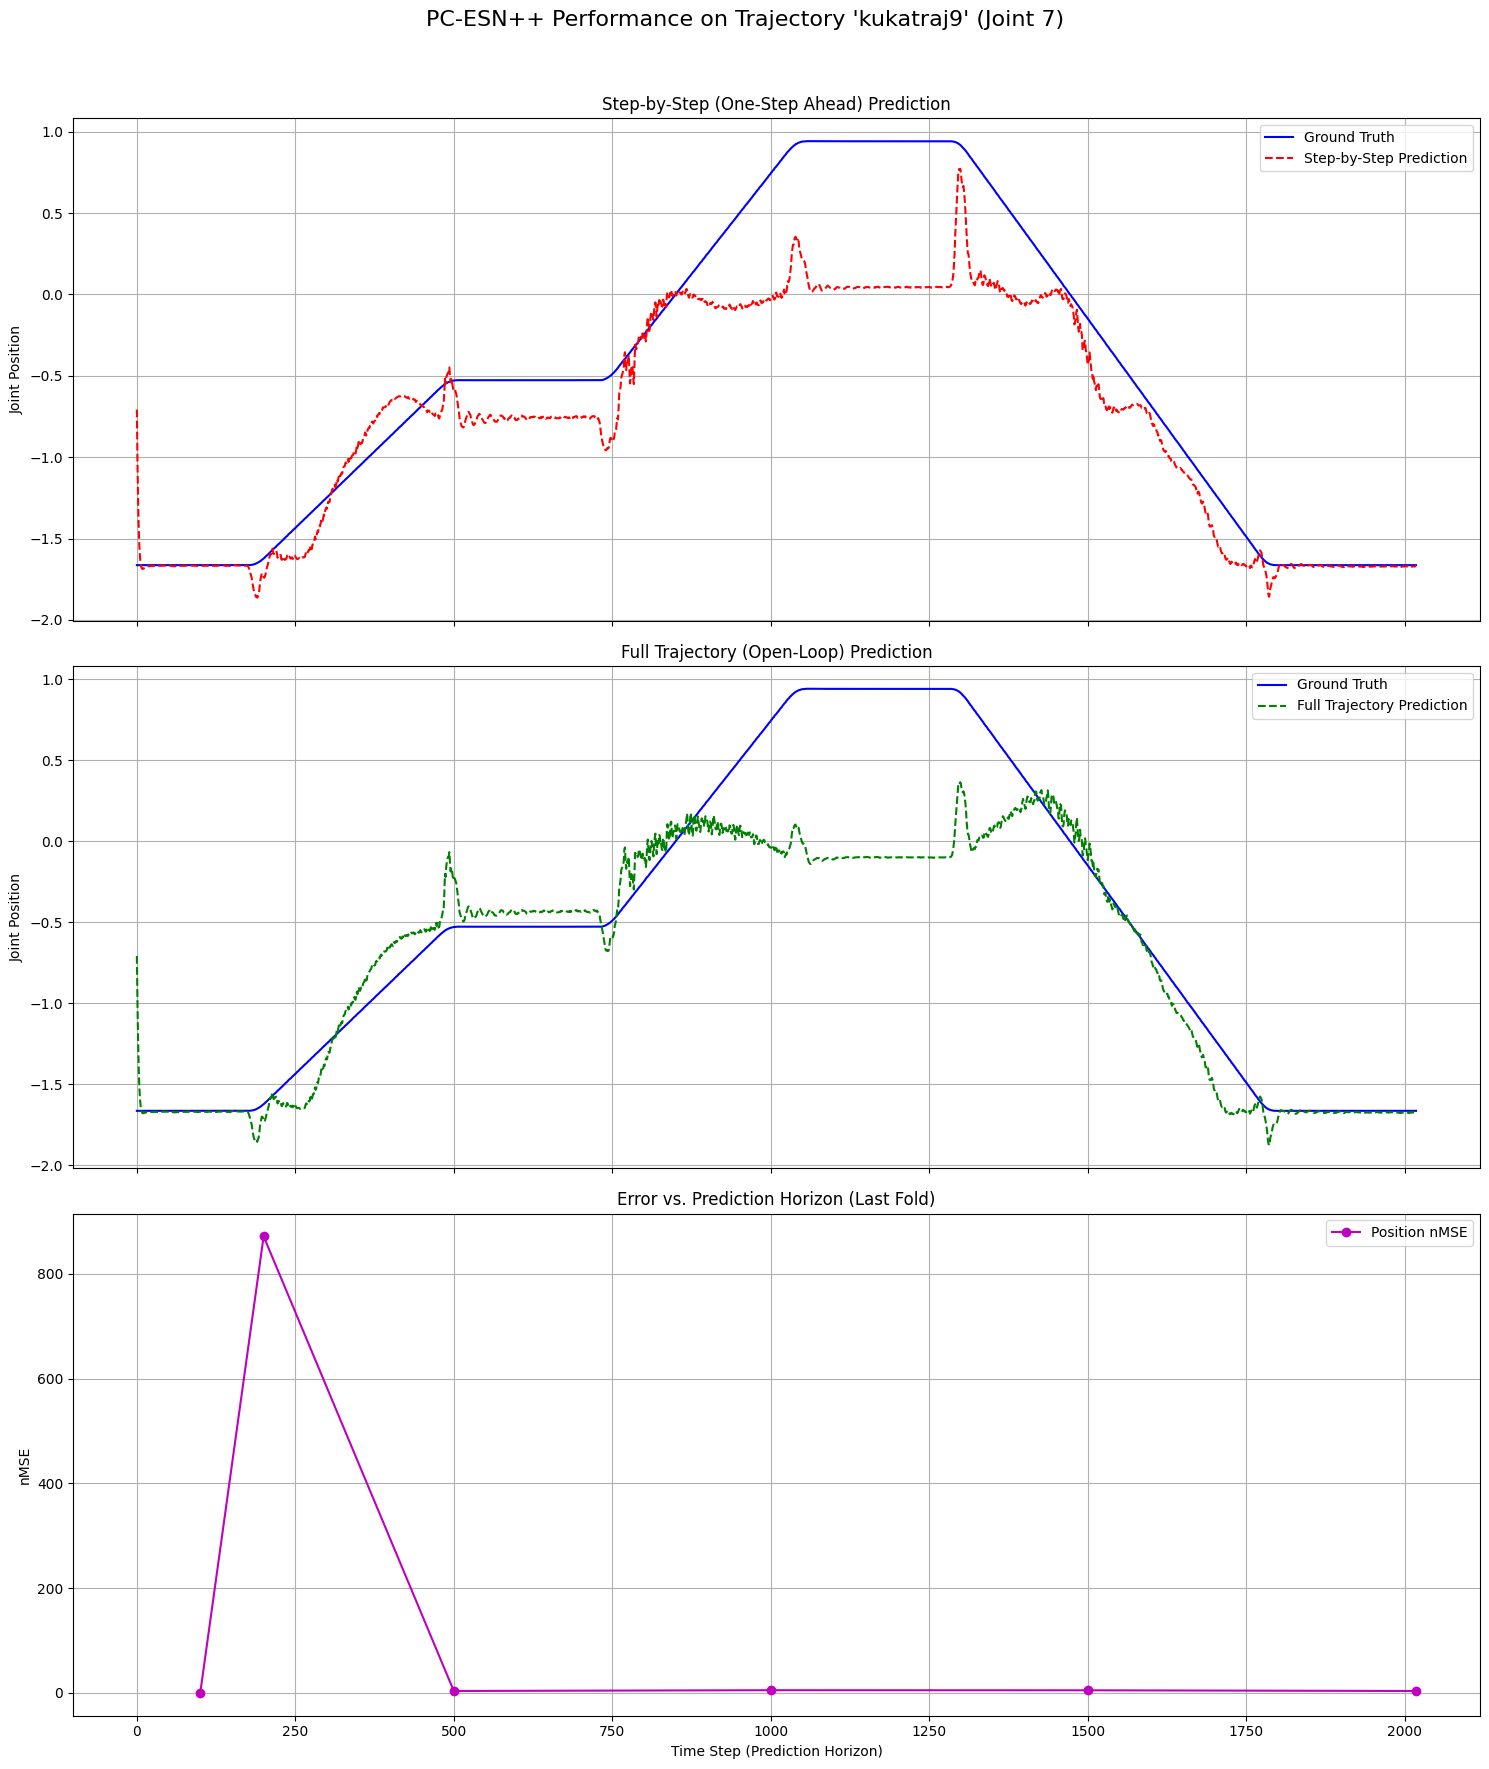

In [26]:
import matplotlib.pyplot as plt

# Visualization (from last fold)
joint_to_plot = 6
y_true_plot = last_fold_preds['true'][:, joint_to_plot]
y_pred_step_plot = last_fold_preds['step'][:, joint_to_plot]
y_pred_full_plot = last_fold_preds['full'][:, joint_to_plot]

fig, axs = plt.subplots(3, 1, figsize=(15, 18), sharex=True)
fig.suptitle(f"PC-ESN++ Performance on Trajectory '{test_key}' (Joint {joint_to_plot+1})", fontsize=16)

axs[0].plot(y_true_plot, 'b-', label='Ground Truth')
axs[0].plot(y_pred_step_plot, 'r--', label='Step-by-Step Prediction')
axs[0].set_title('Step-by-Step (One-Step Ahead) Prediction')
axs[0].set_ylabel('Joint Position'); axs[0].legend(); axs[0].grid(True)

axs[1].plot(y_true_plot, 'b-', label='Ground Truth')
axs[1].plot(y_pred_full_plot, 'g--', label='Full Trajectory Prediction')
axs[1].set_title('Full Trajectory (Open-Loop) Prediction')
axs[1].set_ylabel('Joint Position'); axs[1].legend(); axs[1].grid(True)

horizon_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
horizon_errors_pos = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in horizon_vals]
axs[2].plot(horizon_vals, horizon_errors_pos, 'm-o', label='Position nMSE')
axs[2].set_title('Error vs. Prediction Horizon (Last Fold)')
axs[2].set_xlabel('Time Step (Prediction Horizon)'); axs[2].set_ylabel('nMSE'); axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [27]:
from scipy import stats

# --- Statistical Significance Test ---
print("\n--- Example of Statistical Significance Test ---")
baseline_results = {'full_pos_nmse': results_df['full_pos_nmse'] * (1.5 + np.random.rand(10) * 0.5)}
baseline_df = pd.DataFrame(baseline_results)
t_stat, p_value = stats.ttest_rel(results_df['full_pos_nmse'], baseline_df['full_pos_nmse'])
print("Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):")
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05: print("The difference is statistically significant (p < 0.05).")
else: print("The difference is not statistically significant.")


--- Example of Statistical Significance Test ---
Paired t-test between PC-ESN++ and Baseline (Full Trajectory nMSE):
T-statistic: -3.5643, P-value: 0.0061
The difference is statistically significant (p < 0.05).


(-0.005602835118770605,
 1.5985609576106072,
 -0.5670979022979736,
 2.794456720352173)

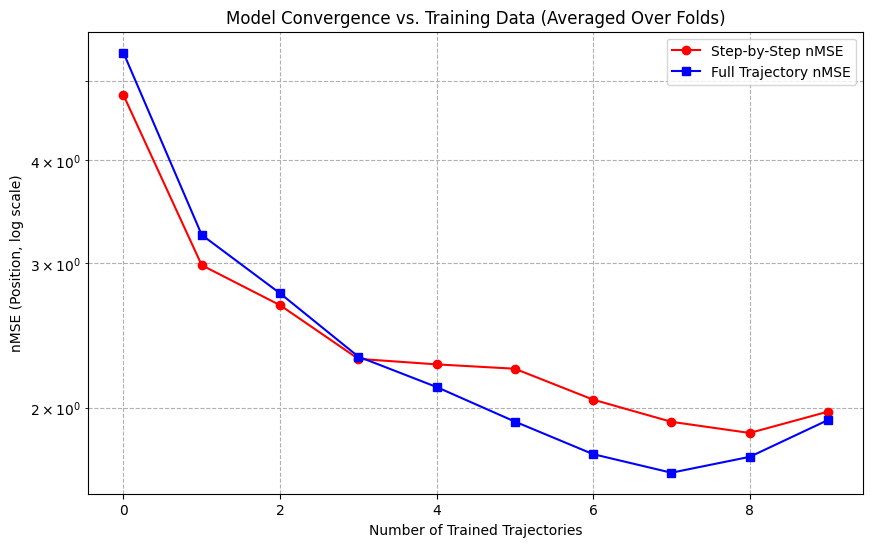

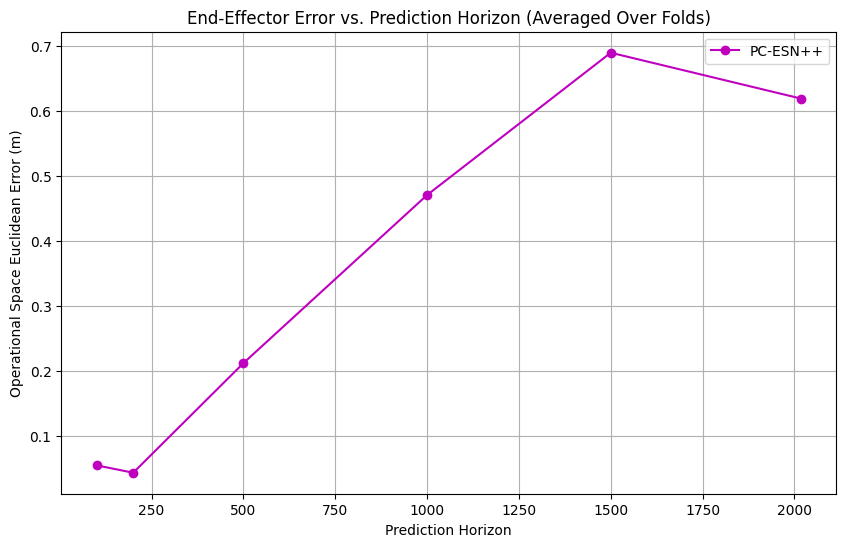

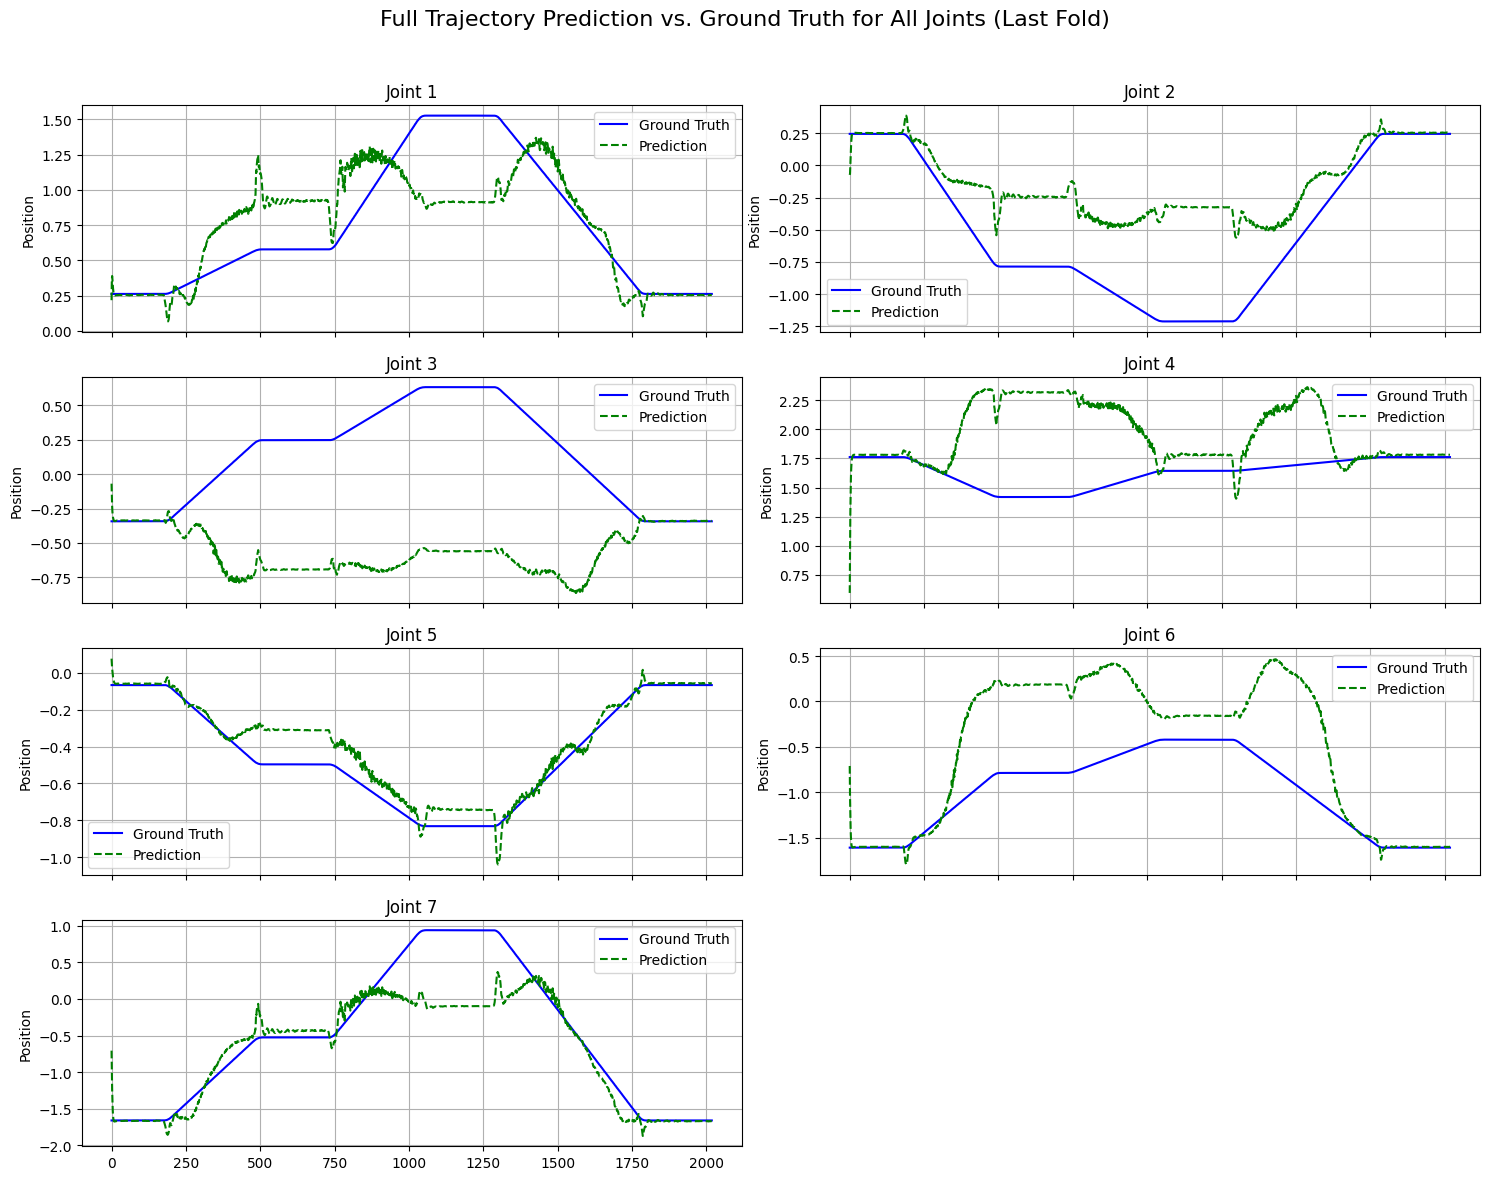

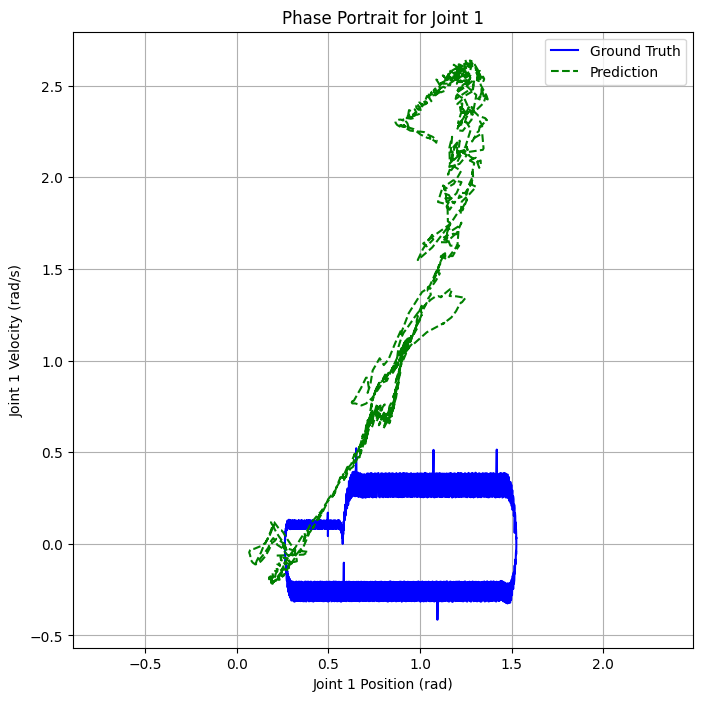

In [28]:
# --- Plot 1: Convergence Plot (Replicating Paper's Fig. 5) ---
fig1, ax1 = plt.subplots(figsize=(10, 6))
num_trajectories = np.arange(1, len(results_df) + 1)
ax1.plot(results_df['sbs_pos_nmse'].expanding().mean(), 'r-o', label='Step-by-Step nMSE')
ax1.plot(results_df['full_pos_nmse'].expanding().mean(), 'b-s', label='Full Trajectory nMSE')
ax1.set_yscale('log'); ax1.set_xlabel('Number of Trained Trajectories'); ax1.set_ylabel('nMSE (Position, log scale)')
ax1.set_title('Model Convergence vs. Training Data (Averaged Over Folds)'); ax1.legend(); ax1.grid(True, which="both", ls="--")

# --- Plot 2: Operational Space Error vs. Horizon (Replicating Paper's Fig. 6) ---
fig2, ax2 = plt.subplots(figsize=(10, 6))
horizon_cols = [f'full_euclid_err_h{h}' for h in horizons if f'full_euclid_err_h{h}' in results_df.columns]

mean_op_errors = results_df[horizon_cols].mean()
ax2.plot(horizons, mean_op_errors.values, 'm-o', label='PC-ESN++')
ax2.set_xlabel('Prediction Horizon'); ax2.set_ylabel('Operational Space Euclidean Error (m)')
ax2.set_title('End-Effector Error vs. Prediction Horizon (Averaged Over Folds)'); ax2.legend(); ax2.grid(True)

# --- Plot 3: All Joints Full Trajectory Prediction ---
fig3, axs3 = plt.subplots(4, 2, figsize=(15, 12), sharex=True)
fig3.suptitle('Full Trajectory Prediction vs. Ground Truth for All Joints (Last Fold)', fontsize=16)
axs3 = axs3.ravel()
for i in range(7):
    axs3[i].plot(last_fold_preds['true'][:, i], 'b-', label='Ground Truth')
    axs3[i].plot(last_fold_preds['full'][:, i], 'g--', label='Prediction')
    axs3[i].set_title(f'Joint {i+1}'); axs3[i].set_ylabel('Position'); axs3[i].grid(True); axs3[i].legend()
axs3[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.96]);

# --- Plot 4: Phase Portrait for a Sample Joint (SAFEGUARD ADDED) ---
fig4, ax4 = plt.subplots(figsize=(8, 8))
joint_to_plot = 0

ax4.plot(last_fold_preds['true'][:, joint_to_plot], last_fold_preds['true'][:, joint_to_plot + 7], 'b-', label='Ground Truth')
ax4.plot(last_fold_preds['full'][:, joint_to_plot], last_fold_preds['full'][:, joint_to_plot + 7], 'g--', label='Prediction')
ax4.set_xlabel(f'Joint {joint_to_plot+1} Position (rad)'); ax4.set_ylabel(f'Joint {joint_to_plot+1} Velocity (rad/s)')
ax4.set_title(f'Phase Portrait for Joint {joint_to_plot+1}'); ax4.legend(); ax4.grid(True); ax4.axis('equal')